In [2]:
import numpy as np
import pandas as pd
import pylab as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

%pylab inline
import warnings
warnings.filterwarnings("ignore")

C:\WBG\anaconda\envs\core_env\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


Populating the interactive namespace from numpy and matplotlib


C:\WBG\anaconda\envs\core_env\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Machine Learning for Cities workshop
November 20, 2018

This notebook gives the source code for the interactive exercises. Participants filled out a survey (56 responses) based on the following fictional scenario:

**A new cohort of 100 staff have just been hired, and will start after Thanksgiving. We need to decide how many bike racks or parking spaces to build for them. To do so, we'll use data on current staff to build a machine learning model. For fun, we'll also predict whether staff prefer classical music or heavy metal.**

The notebook is in Python and makes use of SciKitLearn, the most widely used open source library for machine learning.

### 1. Load and prepare the data

In [3]:
# The data was collected on Google Forms and downloaded as a CSV file.
# We'll load it as a dataframe ('df'), clean up the column names, and take a look.

df = pd.read_csv('survey_responses2.csv')

df.columns = ['gender','household_type','state','favorite_food','exercise_regime','mode_of_travel','arrival_time','music_choice','purchase_history','age']
df = df[['gender','household_type','state','favorite_food','exercise_regime','purchase_history','age','music_choice','arrival_time','mode_of_travel']]

df.head()

,gender,household_type,state,favorite_food,exercise_regime,purchase_history,age,music_choice,arrival_time,mode_of_travel
0,Male,I live with my family.,DC,Steak,Keep fit through jogging or gym.,"Bluetooth speaker / headphones, Theater tickets",35-44,Heavy metal / rock,9:00:00 AM,Walk or bike
1,Female,I live by myself or with housemates.,DC,Mexican,Keep fit through jogging or gym.,Theater tickets,35-44,Classical music,7:30:00 AM,Walk or bike
2,Male,I live by myself or with housemates.,DC,Home cooking,Keep fit through jogging or gym.,Theater tickets,25-34,Classical music,9:30:00 AM,Train
3,Male,I live with my family.,DC,Home cooking,Keep fit through jogging or gym.,"Gardening or home improvement gear, Bluetooth ...",35-44,Classical music,9:00:00 AM,Walk or bike
4,Female,I live by myself or with housemates.,DC,Home cooking,Keep fit through jogging or gym.,"Gardening or home improvement gear, Bluetooth ...",25-34,Classical music,8:30:00 AM,Walk or bike


### 2. Inspect the data
* Before building a model, visualize the data to understand what's in it.

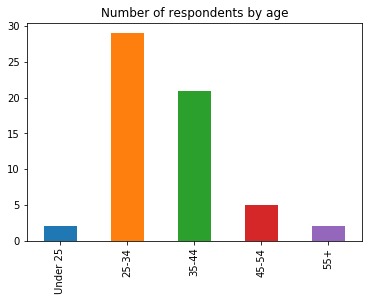

In [4]:
# Our respondents are from a broad set of ages

pd.Series(df.age.value_counts(sort=False),
          index=['Under 25','25-34','35-44','45-54','55+']).plot(kind='bar',title='Number of respondents by age')

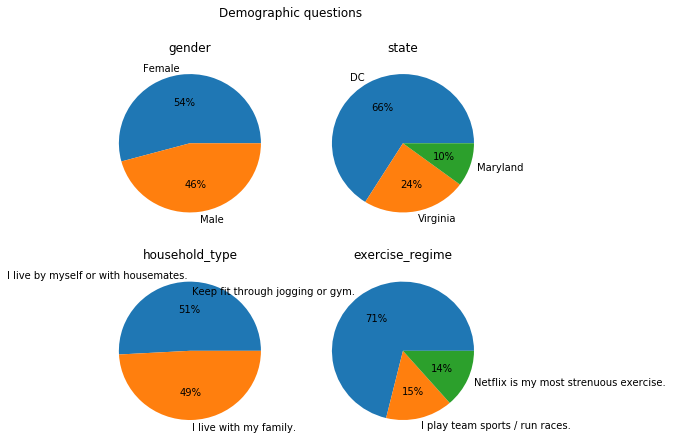

In [5]:
# There are slightly more women than men, and the majority live in DC.

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=[7,7])
pies = ['gender','state','household_type','exercise_regime']

for n,i in enumerate(pies):
    ax = axes.flatten()[n]
    df[i].value_counts().plot(kind='pie',autopct='%1.0f%%',ax=ax)
    ax.set(ylabel='',title=i)

fig.suptitle("Demographic questions");

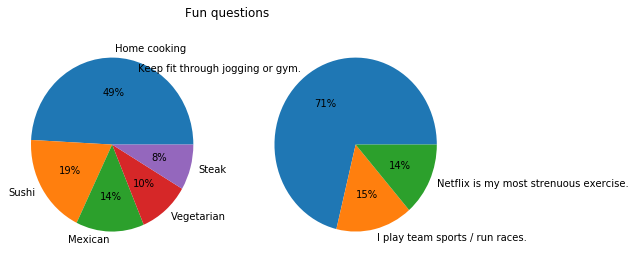

In [6]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=[8,4])
pies = ['favorite_food','exercise_regime']

for n,i in enumerate(pies):
    ax = axes.flatten()[n]
    df[i].value_counts().plot(kind='pie',autopct='%1.0f%%',ax=ax)
    ax.set(ylabel='')
fig.suptitle('Fun questions');

#### --> We'll use supervised learning methods, so the target variable is crucial. We have two target variables: mode of transport and music choice. The classes are fairly evenly balanced.

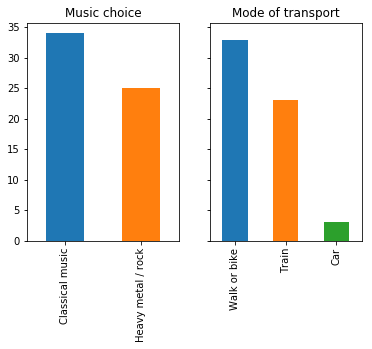

In [7]:
fig,axes = plt.subplots(1,2,sharey=True)
df.mode_of_travel.value_counts().plot(kind='bar',ax=axes[1],title='Mode of transport')
df.music_choice.value_counts().plot(kind='bar',ax=axes[0],title='Music choice')

### 3. Create a machine-readable set of features
We need to transform the data a bit before our algorithm can work with it:
* For categorical features (eg. State = DC, Maryland or Virginia), transform them into dummy variables.
* This will give us a new column for each possible value, encoded as 0 or 1. (So if you live in DC, you'll be marked '1' in the DC column and '0' in the Virginia and Maryland columns.

In [8]:
# Transform the purchases data from string (eg. 'yoga mat, theater tickets') to a list.  

df.purchase_history = df.purchase_history.astype(str)
df.purchase_history = [cell.split(',') for cell in df.purchase_history]  

In [9]:
# Create dummies for purchase history

items = ['Theater tickets','Yoga mat','Bluetooth speaker / headphones',
             'Gardening or home improvement gear',' Presents for my kids']

for item in items:
    df[item] = [item in cell for cell in df.purchase_history]
    df[item] = df[item].map({False:0,True:1})

In [10]:
# Transform gender, household_type, state, food and exercise to dummies

for feature in ['gender','household_type','state','favorite_food','exercise_regime']:
    dummy_feature = pd.get_dummies(df[feature])
    df = pd.concat([df,dummy_feature], axis=1)

In [11]:
# Take the mid-point of the age range
df['age_'] = df.age.map({'Under 25':20,'25-34':29.5,'35-44':39.5,'45-54':49.5,'55+':60})

In [12]:
# Map the TRANSPORT and MUSIC_CHOICE columns (our target variables) to 0s/1s

y_transport = df.mode_of_travel.map({'Train':0,'Car':0,'Walk or bike':1})
y_music = df.music_choice.map({'Classical music':0,'Heavy metal / rock':1})

# Note, we're using the following binary values:

# TRANSPORT -- Train or car: 0, Walk or bike, 1
# MUSIC -- Classical: 0, Heavy metal / rock: 1

In [17]:
df[X].head(3) # Processed set of features:

,Theater tickets,Yoga mat,Bluetooth speaker / headphones,Gardening or home improvement gear,Presents for my kids,age_,Female,Male,I live by myself or with housemates.,I live with my family.,...,Maryland,Virginia,Home cooking,Mexican,Steak,Sushi,Vegetarian,I play team sports / run races.,Keep fit through jogging or gym.,Netflix is my most strenuous exercise.
0,0,0,1,0,0,39.5,0,1,0,1,...,0,0,0,0,1,0,0,0,1,0
1,1,0,0,0,0,39.5,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,1,0,0,0,0,29.5,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0


### 4. Build decision tree models

##### 4.1 TRANSPORT

In [18]:
# In machine learning, the set of predictive features is typically denoted X and the target variable y.
# This reflects mathematical notation where y = f(X)   [outcome y is a function of input features x1 ... xN]

# Here are the feature we'll use:

X = ['Theater tickets', 'Yoga mat', 'Bluetooth speaker / headphones', 'Gardening or home improvement gear',
       ' Presents for my kids', 'age_', 'Female', 'Male',
       'I live by myself or with housemates.', 'I live with my family.', 'DC',
       'Maryland', 'Virginia', 'Home cooking', 'Mexican', 'Steak', 'Sushi',
       'Vegetarian', 'I play team sports / run races.',
       'Keep fit through jogging or gym.','Netflix is my most strenuous exercise.']

In [19]:
# Split the data into training and test sets. We take 70% of data to train the model, 30% to evaluate it.

from sklearn.model_selection import train_test_split

X_train_transport, X_test_transport, y_train_transport, y_test_transport = train_test_split(df[X],y_transport,test_size=0.3)

In [20]:
# X_train is the features for our training set, y_train is the corresponding labels (eg. 'classical fan','heavy metal lover')

print("rows and columns in X_train: {}".format(X_train_transport.shape))
print("rows and columns in y_train: {}".format(y_train_transport.shape))
print("rows and columns in X_test: {}".format(X_test_transport.shape))
print("rows and columns in y_test: {}".format(y_test_transport.shape))

rows and columns in X_train: (41, 21)
rows and columns in y_train: (41,)
rows and columns in X_test: (18, 21)
rows and columns in y_test: (18,)


In [21]:
# First set up the model that we'll use:

tree_transport = DecisionTreeClassifier(max_depth=3,min_samples_leaf=3)

# Then pass it the training data:

tree_transport.fit(X_train_transport,y_train_transport)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

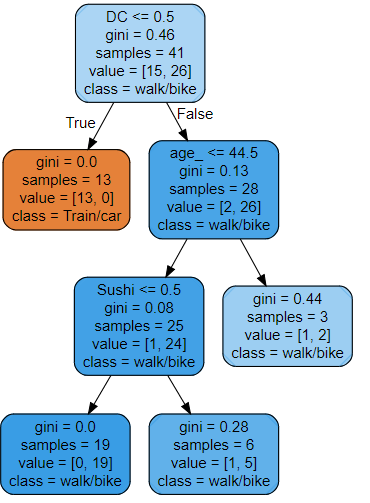

In [291]:
# Visualize the model

export_graphviz(tree_transport, out_file='tree.dot', 
                feature_names = X,
                class_names = ['Train/car','walk/bike'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from IPython.display import Image
Image('tree1.png')

##### 4.2 MUSIC CHOICE

In [22]:
X_train_music, X_test_music, y_train_music, y_test_music = train_test_split(df[X],y_music,test_size=0.3)

In [61]:
tree_music = DecisionTreeClassifier(max_depth=3)
tree_music.fit(X_train_music,y_train_music)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [ ]:
export_graphviz(tree_music, out_file='tree2.dot', 
                feature_names = X,
                class_names = ['Classical','Metal'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

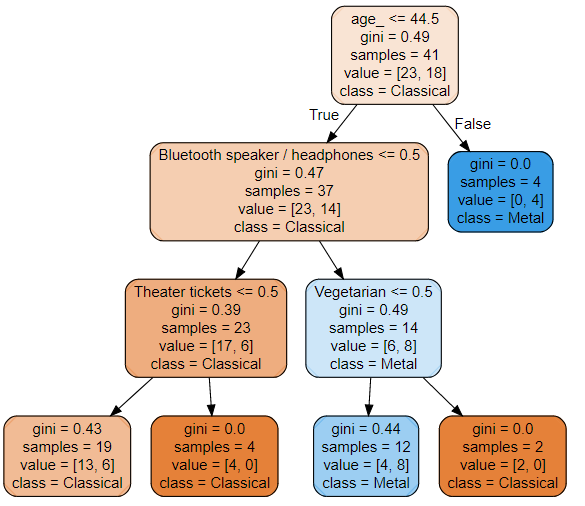

In [302]:
Image('tree2.png')

### 4. Predict against test set, evaluate performance

In [41]:
# We built a decision tree classifier with the training data. Now let's run the test data through it.
# We'll output the predictions it made and look at them:

predictions_transport = tree_transport.predict(X_test_transport)

print("TRANSPORT: First 10 predictions: {}".format(predictions_transport[:10].tolist()))

TRANSPORT: First 10 predictions: [0, 1, 1, 0, 0, 1, 1, 1, 1, 0]


In [26]:
n_samples = len(predictions_transport)

In [27]:
# Is the model any good? Let's check how many of the predicted value equal the actual values.

n_correct = sum(predictions_transport == y_test_transport)
accuracy = n_correct / n_samples * 100

print("TRANSPORT - We predicted {} right out of {} examples. That's a {:.1f} % accuracy rate.".format(
    n_correct,n_samples,accuracy))

TRANSPORT - We predicted 15 right out of 18 examples. That's a 83.3 % accuracy rate.


In [46]:
# Plot a confusion matrix
# This is a widely used tool that plots predicted against actual values, showing which classification errors are being made.

from sklearn.metrics import confusion_matrix 

confusion_matrix = pd.DataFrame(confusion_matrix(predictions_transport,y_test_transport))

confusion_matrix.columns=['Predicted: car-train','Walk-bike']
confusion_matrix.index=['Car-train','Walk-bike']

confusion_matrix.index.name = 'Actual:'
confusion_matrix

,Predicted: car-train,Walk-bike
Actual:,,
Car-train,8,2
Walk-bike,1,7


--> What could boost the prediction accuracy? Two approaches: get more data to train your models on, or improve the model.

### 5. Will a more complex model give us better accuracy?
* Random Forest is an algorithm that builds a decisions of decision trees, each with a slightly different subset of the training data, then makes predictions by averaging the results of each tree. 
* Building a large 'forest' can boost prediction accuracy. But a complex model risks overfitting the data, and benefits of adding more trees peaks after a while.

In [49]:
from sklearn.model_selection import cross_val_score       # This is a variant on train-test split.

In [50]:
n_estimators = np.arange(1,50)           # We'll build a Random Forest with 1 tree, 2 trees, 3 trees, etc, up to 50 trees.
results = []                             # We'll test the prediction accuracy of each model, and store the results.

In [51]:
for i in n_estimators:
    transport_rf = RandomForestClassifier(n_estimators=i, max_depth = 4, min_samples_leaf=3,random_state=1)
    scores = cross_val_score(transport_rf,df[X],y_transport,cv=5)
    results.append(scores.mean())

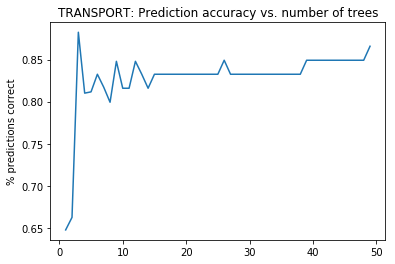

In [52]:
plt.plot(n_estimators,results)
fig=plt.gca()
fig.set(title="TRANSPORT: Prediction accuracy vs. number of trees",ylabel='% predictions correct');

--> performance rises with the number of trees, then levels off. It may be worth using a RF with say 10-15 trees. No need for more than 20. Note that on large and complex datasets (eg. all the buildings in a city), using many trees is worthwhile (100s or even 1000s).

### 6. Demo of parameter tuning
ML models have parameters, eg. for a decision-tree you can specify the maximum depth and the minimum number of samples to include in any split. We'll tune the model by trying different parameters to find the combination that works best.

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:
# First let's specify the set of parameters to look at, and the values to search among.
# ---> we'll try any number of trees between 2 and 40, and several options for max depth and minimum samples per leaf.

param_grid = {'n_estimators':np.arange(2,40),'max_depth':[3,4,5,6],'min_samples_leaf':[2,3,4,5]}

In [58]:
# We'll build a new model for each combination of the parameters (this is a Grid Search), and store the results.

grid_search = GridSearchCV(RandomForestClassifier(),param_grid,cv=5)
grid_search.fit(X_train_transport,y_train_transport)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 4, 5, 6], 'min_samples_leaf': [2, 3, 4, 5], 'n_estimators': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:
print("The best parameters were: {}".format(grid_search.best_params_))
print("The best model classified {} percent of examples correctly.".format((grid_search.best_score_*100).round(1)))

The best parameters were: {'n_estimators': 10, 'min_samples_leaf': 2, 'max_depth': 3}
The best model classified 87.8 percent of examples correctly.


### 7. Demo of feature importance
* Sometimes we want to know which features the model made use of. This helps inform us about what set of rules just got constructed. It's also informative in its own right: eg. in education policy, you might not need to predict student performance, but finding out which factors influence most strongly is of interest.

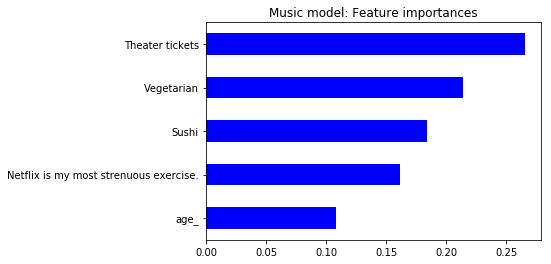

In [63]:
tree_music = DecisionTreeClassifier(max_depth=5)
tree_music.fit(X_train_music,y_train_music)

feat_importance = pd.Series(tree_music.feature_importances_,index=df[X].columns)
feat_importance.nlargest(5).plot(kind='barh',title='Music model: Feature importances',colors='b')
plt.gca().invert_yaxis();

In [64]:
rf_transport = RandomForestClassifier()
rf_transport.fit(X_train_transport,y_train_transport,);

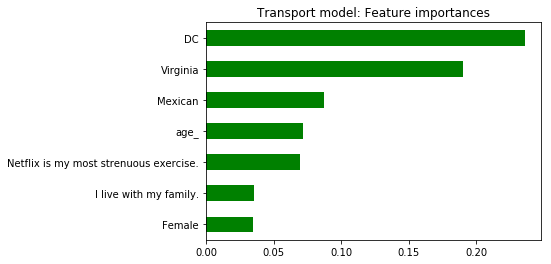

In [65]:
feat_importance = pd.Series(rf_transport.feature_importances_,index=df[X].columns)
feat_importance.nlargest(7).plot(kind='barh',title='Transport model: Feature importances',colors='g')
plt.gca().invert_yaxis();

#### Thanks for participating! Contacts: Nick Jones (njones@worldbank.org), Jon Kastelan (jlk635@nyu.edu)